-----
# cartoGRAPHs - FIGURE 2B and Extended Data figure 4
-----

In [1]:
from cartoGRAPHs import * 

DEBUG: in init: import modules
DEBUG:in cartographs
DEBUG:in cartographs - import done
DEBUG: in init: import done


In [42]:
# delete once the package is updated 

from shapely import geometry

def load_datamatrix(G,organism,netlayout):
    '''
    Load precalculated Matrix with N genes and M features.
    Input: 
    - path = directory of file location
    - organism = string; choose from 'human' or 'yeast'
    - netlayout = string; choose a network layout e.g. 'local', 'global', 'importance', 'funct-bio', 'funct-cel', 'funct-mol', funct-dis'

    Return Matrix based on choice.
    '''
    path = 'input/'
    
    if netlayout == 'local':
        return pd.read_pickle(path+'Adjacency_Dataframe_'+organism+'.pickle')
    
    elif netlayout == 'global':
        return pd.read_pickle(path+'RWR_Dataframe_'+organism+'.pickle')
    
    elif netlayout == 'importance':
        return pd.read_pickle(path+'Matrix_centrality_Dataframe_'+organism+'_cosine.pickle')
    
    elif netlayout == 'funct-bio' and organism == 'human':
        return pd.read_pickle('input/Matrix_goBP_Dataframe_Human_cosine.pickle') #pd.read_pickle('input/Features_BioProc_Dataframe_human.pickle')
    
    elif netlayout == 'funct-mol' and organism == 'human':
        return pd.read_pickle('input/Matrix_goMF_Dataframe_Human_cosine.pickle') #pd.read_pickle('input/Features_MolFunc_Dataframe_human.pickle')
    
    elif netlayout == 'funct-cel' and organism == 'human':
        return pd.read_pickle('input/Matrix_goCC_Dataframe_Human_cosine.pickle') #pd.read_pickle('input/Features_GO_CellComp_Dataframe_human.pickle')
    
    elif netlayout == 'funct-dis' and organism == 'human':
        return pd.read_pickle('input/Matrix_Disease_Dataframe_Human_cosine.pickle') #pd.read_pickle('input/Features_Disease_Dataframe_human.pickle')
    
    else: 
        print('Please type one of the following: "local", "global", "importance", "funct-dis/bio/cel/mol"')

        
def plot_2D(data,path,fname,scheme='light', plot_title = None):
    '''
    Create a 2D plot from traces using plotly.
    Input: 
    - data = list of traces
    - filename = string
    - scheme = 'light' or 'dark'
    - plot_title = string; optional title of plot
    
    Return plot in 2D and file, saved as png.
    '''

    fig = pgo.Figure()
    
    for i in data:
        fig.add_trace(i)
       
    if scheme == 'light':
        fig.update_layout(template= 'plotly_white', 
                          showlegend=False, 
                          width=1200, height=1200,
                              scene=dict(
                                  xaxis_title='',
                                  yaxis_title='',
                                  xaxis=dict(nticks=0,tickfont=dict(
                                        color='white')),
                                  yaxis=dict(nticks=0,tickfont=dict(
                                        color='white')),
                            ))  
        
    elif scheme == 'dark':
        fig.update_layout(template= 'plotly_dark', 
                          showlegend=False, 
                          width=1200, height=1200,
                              scene=dict(
                                  xaxis_title='',
                                  yaxis_title='',
                                  xaxis=dict(nticks=0,tickfont=dict(
                                        color='black')),
                                  yaxis=dict(nticks=0,tickfont=dict(
                                        color='black')),
                            ))  
    else:
        print('Oops, something went wrong. Please check input parameters.')

    fig.update_layout(title_text = plot_title)
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.write_html(path+fname+'.html')
    
    return plotly.offline.plot(fig, filename = path+fname+'.html', auto_open=True)


def embed_umap_2D(Matrix, n_neigh, spre, m_dist, metric='cosine', learn_rate = 1, n_ep = None):
    '''
    Dimensionality reduction from Matrix using UMAP.
    Return dict (keys: node IDs, values: x,y).
    ''' 
    n_comp = 2 
    SEED = 100
    
    U = umap.UMAP(
        n_neighbors = n_neigh,
        spread = spre,
        min_dist = m_dist,
        n_components = n_comp,
        metric = metric, 
        random_state=SEED, #np.random.seed(SEED),
        learning_rate = learn_rate, 
        n_epochs = n_ep)
    
    embed = U.fit_transform(Matrix)
    
    return embed


def layout_portrait_umap(G, DM, dim, n_neighbors=8, spread=1.0, min_dist=0.0, metric='cosine',r_scale = 1.2):
    
    if dim == 2:
        umap2D = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)
        posG = get_posG_2D_norm(G, DM, umap2D,r_scale)
        
        return posG
    
    elif dim == 3:
        umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)
        posG = get_posG_3D_norm(G, DM, umap_3D,r_scale)

        return posG
        
    else:
        print('Please choose dimensions, by either setting dim=2 or dim=3.')
        
    
def get_posG_2D_norm(G, DM, embed, r_scalingfactor):
    '''
    Generate coordinates from embedding. 
    Input:
    - G = Graph
    - DM = matrix; index and columns must be same as G.nodes
    - embed = embedding from e.g. tSNE , UMAP ,... 
    
    Return dictionary with nodes as keys and coordinates as values in 3D normed. 
    '''
    
    if isinstance(DM, np.ndarray):
        df_DM = pd.DataFrame(DM, index=list(G.nodes()), columns=list(G.nodes()))
        DM = df_DM
        
    elif isinstance(DM, pd.DataFrame):
        DM = DM 
    
    else: 
        print('Please enter a Matrix of type pd.DataFrame with any number, up to len(G.nodes()) rows and columns or a numpy array with len(G.nodes()) rows and columns in the same order of G.nodes().')
        
        
    genes = []
    for i in DM.index:
        if i in G.nodes(): #if str(i) in G.nodes() or int(i) in G.nodes():
            #genes.append(str(i))
            genes.append(i)

    genes_rest = [] 
    for i in G.nodes():
        if i not in genes:
            #genes_rest.append(str(i))
            genes_rest.append(i)

    posG = {}
    cc = 0
    for entz in genes:
        posG[entz] = (embed[cc,0],embed[cc,1])
        cc += 1

    #--------------------------------------------------------------
    # REST (if genes = G.nodes then rest will be ignored / empty)
    
    # generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
    t = np.random.uniform(0,2*np.pi,len(genes_rest))
    
    xx=[]
    yy=[]
    for i in posG.values():
        xx.append(i[0])
        yy.append(i[1])
    
    cx = np.mean(xx)
    cy = np.mean(yy)

    xm, ym = max(posG.values())
    r = (math.sqrt((xm-cx)**2 + (ym-cy)**2))*r_scalingfactor #*1.05 # multiplying with 1.05 makes cirle larger to avoid "outsider nodes/genes"
        
    x = r*np.cos(t)
    y = r*np.sin(t)
    rest = []
    for i,j in zip(x,y):
            rest.append((i,j))

    posG_rest = dict(zip(genes_rest, rest))

    posG_all = {**posG, **posG_rest}
    
    #G_nodes_str = [str(i) for i in list(G.nodes())]
    posG_complete = {key:posG_all[key] for key in list(G.nodes())}

    # normalize coordinates 
    x_list = []
    y_list = []
    for k,v in posG_complete.items():
        x_list.append(v[0])
        y_list.append(v[1])

    xx_norm = preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
    yy_norm = preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)

    xx_norm_final=[]
    for i in xx_norm:
        xx_norm_final.append(round(i,10))

    yy_norm_final=[]
    for i in yy_norm:
        yy_norm_final.append(round(i,10))

    posG_complete_norm = dict(zip(list(G.nodes()),zip(xx_norm_final,yy_norm_final)))
    
    return posG_complete_norm

_____
# HUMAN PPI NETWORK
_____

In [ ]:
organism = 'human'
G = load_graph(organism)

d_centralities = load_centralities(G, organism)
df_centralities = pd.DataFrame(d_centralities).T
df_centralities.columns = ['degree','closeness', 'betweeness', 'eigenvector']
essential_genes,non_ess_genes,notdefined_genes = load_essentiality(G, organism)

d_gene_sym = load_genesymbols(G, organism)
l_features = list(d_gene_sym.values())

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

netlayout = 'funct-dis'
Matrix = load_datamatrix(G,organism, netlayout)

-----
# FIGURE 2B 
-----

## SCALE SPECIFIC DISEASES IN FEATURE MATRIX 
Figure 2B original 

+ DOID:305 - carcinoma
+ DOID:5419 - schizophrenia
+ DOID:423 - myopathy
+ DOID:1612 - breast cancer

In [ ]:
scaling_value = 1
netlayout = 'FMscal'+str(scaling_value)

# get Disease Feature Matrix Original
FM_disease = pd.read_pickle('input/Features_Disease_Dataframe_'+organism+'.pickle')
FM = FM_disease
FM.index = FM.index.map(str)

# first Disease
num_doid_1 = '305' #CARCINOMA
dismod_1 = FM_disease.loc[:,'DOID:'+num_doid_1]
dismod_1.index = FM_disease.index

# second Disease
num_doid_2 = '5419' #SCHIZOPHRENIA
dismod_2 = FM_disease.loc[:,'DOID:'+num_doid_2]
dismod_2.index = FM_disease.index

# third Disease 
num_doid_3 = '423' #MYOPATHY
dismod_3 = FM_disease.loc[:,'DOID:'+num_doid_3]
dismod_3.index = FM_disease.index

# fourth Disease 
num_doid_4 = '1612' #BREAST CANCER
dismod_4 = FM_disease.loc[:,'DOID:'+num_doid_4]
dismod_4.index = FM_disease.index

FM.loc[FM_disease['DOID:'+num_doid_1] !=0, 'DOID:'+num_doid_1] = scaling_value
FM.loc[FM_disease['DOID:'+num_doid_2] !=0, 'DOID:'+num_doid_2] = scaling_value
FM.loc[FM_disease['DOID:'+num_doid_3] !=0, 'DOID:'+num_doid_3] = scaling_value
FM.loc[FM_disease['DOID:'+num_doid_4] !=0, 'DOID:'+num_doid_4] = scaling_value

_____ 
## SPATIAL EMBEDDING
_____

### PORTRAIT

In [ ]:
%%time 

nn = 8
spr = 1.0
md = 0.75 #0.25 
Matrix = FM

posG_umap2D = layout_portrait_umap(G,
                                   Matrix,
                                   2,
                                   n_neighbors=nn, 
                                   spread=spr, 
                                   min_dist=md, 
                                   metric='cosine', #'euclidean', #'cosine',
                                   r_scale=1.2) #1.35 #1.75
posG = posG_umap2D


#posG_tsne3D_ = layout_portrait_tsne(G,Matrix,3,prplxty=10, density=1, l_rate=200, steps=250, metric='cosine') 
#posG = posG_tsne3D

#posG_umap3D = layout_portrait_umap(G,Matrix,3,n_neighbors=20, spread=1, min_dist=0.0, metric='cosine') 
#posG = posG_umap3D

____________
## VISUAL SETTINGS + PLOT PREPARATION
____________

### COLORS BASED ON DISEASE MODULES 

In [ ]:
#
# DISEASE 1 | ORANGE
#

node_col_1 = '#FF9300' #orange

dismod_genes_1 = [] 
for i,v in enumerate(dismod_1.values):
    if v == 1 or v == scaling_value:
        dismod_genes_1.append(dismod_1.index[i])
    else:
        pass

l_genes_dismod_1 = [str(i) for i in dismod_genes_1]
print('Number of Genes associated to DOID', num_doid_1,':',len(l_genes_dismod_1))

# color edges    
d_edge_col_1 = color_edges_from_nodelist_specific(G, l_genes_dismod_1, node_col_1)

center_dis_1_sym = 'SPRR1A' 

# get nodeID of gene symbol 
for ix, sym in d_gene_sym.items():
    if sym == center_dis_1_sym:
        center_dis_1_id = ix

# get coordinates from nodeID
for node, coords in posG.items():
    if node == center_dis_1_id:
        center_dis_1_coords = coords

# make shapely point from defined center of cluster 
point_1 = geometry.Point(center_dis_1_coords[0], center_dis_1_coords[1])

# create your circle buffer from one of the points
distance = 0.05
circle_buffer = point_1.buffer(distance)

# get list of genes that are within radius around the center 
l_genes_circlebuffer_1 = []
for node,coords in posG.items():
    point = geometry.Point(coords[0], coords[1])
    if point.within(circle_buffer): 
        l_genes_circlebuffer_1.append(node)
        
print('Number of genes within radius around Center - Disease 1:' ,len(l_genes_circlebuffer_1))

# get edges in between nodes within radius around center 

l_links_circlebuffer_1 = []
for edge in G.edges():    
    if edge[0] in l_genes_circlebuffer_1 and edge[1] in l_genes_circlebuffer_1 and edge[0] in l_genes_dismod_1 and edge[1] in l_genes_dismod_1:
        l_links_circlebuffer_1.append(edge)
        
print('Number of links in circle buffer - Disease 1:', len(l_links_circlebuffer_1))

# color edges within circle buffer     
d_edge_col_circlebuffer_1 = color_edges_from_nodelist_specific(G, l_genes_circlebuffer_1, node_col_1)

In [ ]:
#
# DISEASE 2 | YELLOW
#

node_col_2 = '#FFC500' #'#ffe700' #yellow

dismod_genes_2 = [] 
for i,v in enumerate(dismod_2.values):
    if v == 1 or v == scaling_value:
        dismod_genes_2.append(dismod_2.index[i])
    else:
        pass
    
l_genes_dismod_2 = [str(i) for i in dismod_genes_2]
print('Number of Genes associated to DOID', num_doid_2,':',len(l_genes_dismod_2))

# color edges 
d_edge_col_2 = color_edges_from_nodelist_specific(G, l_genes_dismod_2, node_col_2)


center_dis_2_sym = 'SLC7A10' 
# get nodeID of gene symbol 
for ix, sym in d_gene_sym.items():
    if sym == center_dis_2_sym:
        center_dis_2_id = ix

# get coordinates from nodeID
for node, coords in posG.items():
    if node == center_dis_2_id:
        center_dis_2_coords = coords

# make shapely point from defined center of cluster 
point_2 = geometry.Point(center_dis_2_coords[0], center_dis_2_coords[1])

# create your circle buffer from one of the points
distance = 0.1
circle_buffer = point_2.buffer(distance)

# get list of genes that are within radius around the center 
l_genes_circlebuffer_2 = []
for node,coords in posG.items():
    point = geometry.Point(coords[0], coords[1])
    if point.within(circle_buffer): 
        l_genes_circlebuffer_2.append(node)
        
print('Number of genes within radius around Center - Disease 2:' ,len(l_genes_circlebuffer_2))

# get edges in between nodes within radius around center 

l_links_circlebuffer_2 = []
for edge in G.edges():    
    if edge[0] in l_genes_circlebuffer_2 and edge[1] in l_genes_circlebuffer_2 and edge[0] in l_genes_dismod_2 and edge[1] in l_genes_dismod_2:
        l_links_circlebuffer_2.append(edge)
        
print('Number of links in circle buffer - Disease 2:', len(l_links_circlebuffer_2))

# color edges within circle buffer     
d_edge_col_circlebuffer_2 = color_edges_from_nodelist_specific(G, l_genes_circlebuffer_2, node_col_2)

In [ ]:
#
# DISEASE 3 | RED 
#

node_col_3 = '#e50000' #red

dismod_genes_3 = [] 
for i,v in enumerate(dismod_3.values):
    if v == 1 or v == scaling_value:
        dismod_genes_3.append(dismod_3.index[i])
    else:
        pass

l_genes_dismod_3 = [str(i) for i in dismod_genes_3]
print('Number of Genes associated to DOID', num_doid_3,':',len(l_genes_dismod_3))

# color edges    
d_edge_col_3 = color_edges_from_nodelist_specific(G, l_genes_dismod_3, node_col_3)

center_dis_3_sym = 'SGCB' 
# get nodeID of gene symbol 
for ix, sym in d_gene_sym.items():
    if sym == center_dis_3_sym:
        center_dis_3_id = ix

# get coordinates from nodeID
for node, coords in posG.items():
    if node == center_dis_3_id:
        center_dis_3_coords = coords

# make shapely point from defined center of cluster 
point_3 = geometry.Point(center_dis_3_coords[0], center_dis_3_coords[1])

# create your circle buffer from one of the points
distance = 0.05  
circle_buffer = point_3.buffer(distance)

# get list of genes that are within radius around the center 
l_genes_circlebuffer_3 = []
for node,coords in posG.items():
    point = geometry.Point(coords[0], coords[1])
    if point.within(circle_buffer): 
        l_genes_circlebuffer_3.append(node)
        
print('Number of genes within radius around Center - Disease 2:' ,len(l_genes_circlebuffer_3))

# get edges in between nodes within radius around center 

l_links_circlebuffer_3 = []
for edge in G.edges():    
    if edge[0] in l_genes_circlebuffer_3 and edge[1] in l_genes_circlebuffer_3 and edge[0] in l_genes_dismod_3 and edge[1] in l_genes_dismod_3:
        l_links_circlebuffer_3.append(edge)
        
print('Number of links in circle buffer - Disease 2:', len(l_links_circlebuffer_3))

# color edges within circle buffer     
d_edge_col_circlebuffer_3 = color_edges_from_nodelist_specific(G, l_genes_circlebuffer_3, node_col_3)

In [ ]:
#
# DISEASE 4 | DARKRED 
#

node_col_4 = '#a10000' #dark red

dismod_genes_4 = [] 
for i,v in enumerate(dismod_4.values):
    if v == 1 or v == scaling_value:
        dismod_genes_4.append(dismod_4.index[i])
    else:
        pass
    
l_genes_dismod_4 = [str(i) for i in dismod_genes_4]
print('Number of Genes associated to DOID', num_doid_4,':',len(l_genes_dismod_4))

# color edges    
d_edge_col_4 = color_edges_from_nodelist_specific(G, l_genes_dismod_4, node_col_4)

center_dis_4_sym = 'THEMIS2' 
# get nodeID of gene symbol 
for ix, sym in d_gene_sym.items():
    if sym == center_dis_4_sym:
        center_dis_4_id = ix

# get coordinates from nodeID
for node, coords in posG.items():
    if node == center_dis_4_id:
        center_dis_4_coords = coords

# make shapely point from defined center of cluster 
point_4 = geometry.Point(center_dis_4_coords[0], center_dis_4_coords[1])

# create your circle buffer from one of the points
distance = 0.05 #0.08
circle_buffer = point_4.buffer(distance)

# get list of genes that are within radius around the center 
l_genes_circlebuffer_4 = []
for node,coords in posG.items():
    point = geometry.Point(coords[0], coords[1])
    if point.within(circle_buffer): 
        l_genes_circlebuffer_4.append(node)
        
print('Number of genes within radius around Center - Disease 2:' ,len(l_genes_circlebuffer_4))

# get edges in between nodes within radius around center 

l_links_circlebuffer_4 = []
for edge in G.edges():   
    if edge[0] in l_genes_circlebuffer_4 and edge[1] in l_genes_circlebuffer_4 and edge[0] in l_genes_dismod_4 and edge[1] in l_genes_dismod_4:
        l_links_circlebuffer_4.append(edge)
        
print('Number of links in circle buffer - Disease 2:', len(l_links_circlebuffer_4))

# color edges within circle buffer     
d_edge_col_circlebuffer_4 = color_edges_from_nodelist_specific(G, l_genes_circlebuffer_4, node_col_4)

In [ ]:
# highlight DAB1

dab_id = '1600' #d_gene_sym['1600']

# merge all node colors (and sort like G.nodes)
col_param = list(df_centralities['closeness'].values)
d_node_colors = dict(zip(list(G.nodes()), col_param))

c1='#E6E6E6' 
c2='#9B9B9B' 
n=len(set(col_param))

colors_for_palette = []
for x in range(n+1):
    colors_for_palette.append(colorFader(c1,c2,x/n))    

customPalette = sns.set_palette(sns.color_palette(colors_for_palette))
d_colors = color_nodes_from_dict(G, d_node_colors, palette = customPalette)

d_col_all = {}
for k,v in d_colors.items():
 
    if k in l_genes_dismod_4:
        d_col_all[k] = node_col_4
        
    elif k in l_genes_dismod_3:
        d_col_all[k] = node_col_3
        
    elif k in l_genes_dismod_2:
        d_col_all[k] = node_col_2
    
    elif k in l_genes_dismod_1:
        d_col_all[k] = node_col_1
    
    else:
        d_col_all[k]=v
        
colors = list(d_col_all.values())

l_genes_all =  l_genes_dismod_1 + l_genes_dismod_2 + l_genes_dismod_3 + l_genes_dismod_4

---
## PLOT 
---

In [ ]:
opacity_nodes = 0.9
node_edge_col = '#696969' 
node_linewidth = 0.1

# plot nodes based on focus > separate to background/foreground 

posG_foreground = {}
posG_background = {}
for k,v in posG.items():
    if k in l_genes_all:
        posG_foreground[k]=v
    else: 
        posG_background[k]=v
    
d_colors_foreground = {}
d_colors_background = {}
for i,c in d_col_all.items():
    
    if i == dab_id:
        d_colors_foreground[i]='#0000FF'
    
    elif i in posG_foreground.keys():
        d_colors_foreground[i]=c
    else: 
        d_colors_background[i]=c

colors_foreground = list(d_colors_foreground.values())
colors_background = list(d_colors_background.values())

d_feat_foreground = {}
d_feat_background = {}
for k,v in d_gene_sym.items():
    if k in posG_foreground: 
        d_feat_foreground[k]=v
    else:
        d_feat_background[k]=v
        
feat_foreground = list(d_feat_foreground.values())
feat_background = list(d_feat_background.values())

scale_factor = 0.025
d_size_plotly = draw_node_degree_3D(G, scale_factor)  # for zoom: scale_factor/50
d_size_plotly_foreground = {}
d_size_plotly_background = {}
for k,v in d_size_plotly.items():
    
    if k == dab_id:
        d_size_plotly_foreground[k]=20
        
    elif k in posG_foreground.keys():
        d_size_plotly_foreground[k]=v
    else:
        d_size_plotly_background[k]=v
        
size_plotly_foreground = list(d_size_plotly_foreground.values())
size_plotly_background = list(d_size_plotly_background.values())


# -----------    
# N O D E S 
# -----------   
umap_nodes_foreground = get_trace_nodes_2D(posG_foreground, feat_foreground, colors_foreground, 
                                           size_plotly_foreground, #3,
                                           node_linewidth, 0.8)
umap_nodes_foreground_ = get_trace_nodes_2D(posG_foreground, feat_foreground, colors_foreground, 2,
                                           None, 0.1)

umap_nodes_background = get_trace_nodes_2D(posG_background, feat_background, colors_background, 
                                           size_plotly_foreground, #3,
                                           node_linewidth, 0.5) 
umap_nodes_background_ = get_trace_nodes_2D(posG_background, feat_background, colors_background, 2, 
                                           None,0.5)
    
# -----------   
# E D G E S 
# -----------  
opac_shine = 0.08
lw_shine = 3.0
lw_buffer = 0.25
opac_buffer = 0.5 
umap_edges_circlebuffer_1 = get_trace_edges_specific2D(d_edge_col_circlebuffer_1,
                                          posG, linew=lw_buffer, opac=opac_buffer)
umap_edges_circlebuffer_1_shine = get_trace_edges_specific2D(d_edge_col_circlebuffer_1,
                                          posG, linew=lw_shine, opac=opac_shine)

umap_edges_circlebuffer_2 = get_trace_edges_specific2D(d_edge_col_circlebuffer_2,
                                          posG, linew=lw_buffer, opac=opac_buffer)
umap_edges_circlebuffer_2_shine = get_trace_edges_specific2D(d_edge_col_circlebuffer_2,
                                          posG, linew=lw_shine, opac=opac_shine)

umap_edges_circlebuffer_3 = get_trace_edges_specific2D(d_edge_col_circlebuffer_3,
                                          posG, linew=lw_buffer, opac=opac_buffer)
umap_edges_circlebuffer_3_shine = get_trace_edges_specific2D(d_edge_col_circlebuffer_3,
                                          posG, linew=lw_shine, opac=opac_shine)

umap_edges_circlebuffer_4 = get_trace_edges_specific2D(d_edge_col_circlebuffer_4,
                                          posG, linew=lw_buffer, opac=opac_buffer)
umap_edges_circlebuffer_4_shine = get_trace_edges_specific2D(d_edge_col_circlebuffer_4,
                                          posG, linew=lw_shine, opac=opac_shine)

opacity_edges = 0.09
width_edges = 0.25
umap_edges_1 = get_trace_edges_specific2D(d_edge_col_1, 
                                          posG, linew=width_edges, opac=opacity_edges)
umap_edges_2 = get_trace_edges_specific2D(d_edge_col_2, 
                                          posG, linew=width_edges, opac=opacity_edges)
umap_edges_3 = get_trace_edges_specific2D(d_edge_col_3,
                                          posG, linew=width_edges, opac=opacity_edges)
umap_edges_4 = get_trace_edges_specific2D(d_edge_col_4, 
                                          posG, linew=width_edges, opac=opacity_edges)
                                         
data = [
        umap_nodes_background_, 
        umap_nodes_background, 
        
        # all edges 
        umap_edges_1, 
        umap_edges_2,
        umap_edges_3,
        umap_edges_4,
    
        # edges within radius
        umap_edges_circlebuffer_1_shine,
        umap_edges_circlebuffer_2_shine,
        umap_edges_circlebuffer_3_shine,
        umap_edges_circlebuffer_4_shine,
    
        umap_edges_circlebuffer_1, 
        umap_edges_circlebuffer_2, 
        umap_edges_circlebuffer_3, 
        umap_edges_circlebuffer_4, 
        
        umap_nodes_foreground_,
        umap_nodes_foreground]


if len(list(posG.values())[0]) == 2:
    path = 'output_plots/2Dlayouts/'
    schema = 'light' #'dark' 
    fname = 'FIG2B_2Dportrait_DOID'+num_doid_1+'_'+num_doid_2+'_'+num_doid_3+'_'+num_doid_4+'_'+netlayout+'_nn'+str(nn)+'_spr'+str(spr)+'_md'+str(md)+'_'+organism
    fname_withlinks = 'FIG2B_2Dportrait_DOID'+num_doid_1+'_'+num_doid_2+'_'+num_doid_3+'_'+num_doid_4+'_'+netlayout+'_nn'+str(nn)+'_spr'+str(spr)+'_md'+str(md)+'_'+organism+'_links'

    plot_2D(data,path,fname)

elif len(list(posG.values())[0]) == 3:
    path = 'output_plots/3Dlayouts/'
    schema = 'light' #'dark' 
    fname = 'FIG2B_3Dportrait_DOID'+num_doid_1+'_'+num_doid_2+'_'+num_doid_3+'_'+num_doid_4+'_'+netlayout+'_nn'+str(nn)+'_spr'+str(spr)+'_md'+str(md)+'_'+organism
    fname_withlinks = 'FIG2B_3Dportrait_DOID'+num_doid_1+'_'+num_doid_2+'_'+num_doid_3+'_'+num_doid_4+'_'+netlayout+'_nn'+str(nn)+'_spr'+str(spr)+'_md'+str(md)+'_'+organism+'_links'

    plot_3D(data,path,fname, schema)

---
## VRNETZER TABLE
---

In [ ]:
#posG_complete_sphere_norm_num = {}
#for node_id,coords in posG_complete_sphere_norm.items():
#    posG_complete_sphere_norm_num[only_numerics(node_id)]=coords
    
export_to_csv3D(path='_VR_layouts/',
                layout_namespace = layoutcategory+'_'+netlayout, 
                posG = posG, 
                colours = colours)

---
# Extended Data Figure 4
## PLEIOTROPY DIAGRAM
---

#### COLORS BASED ON GRADIENT OF PLEIOTROPY / DISEASE COUNT 

In [22]:
DM_feature = pd.read_pickle('input/Features_Disease_Dataframe_'+organism+'.pickle')

# set gene list (= G.nodes())
genes_assoc = []
for i in DM_feature.index:
    genes_assoc.append(str(i))

genes_notassoc = [] 
for g in G.nodes():
    if g not in genes_assoc:
        genes_notassoc.append(g)

features_counted = (DM_feature == 1).astype(int).sum(axis=1)
d_features_counted = dict(zip(genes_assoc, list(features_counted)))
    
d_rest = {}
for i in genes_notassoc: 
    d_rest[i] = 0

d_param_unsorted = {**d_features_counted, **d_rest}
d_diseasecount = {key:d_param_unsorted[key] for key in G.nodes()}

d_nodecolors = d_diseasecount
col_pal = 'BuPu' # 'crest' #'rocket_r' #'viridis_r' #'YlOrRd'

d_col_all = color_nodes_from_dict(G, d_nodecolors, palette = col_pal)
colors = list(d_colors.values())

d_diseasecount_sortbyvalue = dict(sorted(d_diseasecount.items(), key=lambda item: item[1], reverse=True))
diseasecount_foreground = list(d_diseasecount_sortbyvalue.keys())[:1000]
l_genes_all = diseasecount_foreground

---
## PLOT 
---

In [23]:
opacity_nodes = 0.8
node_edge_col = '#696969' 
node_linewidth = 0.25

scale_factor = 0.45
size = list(draw_node_degree(G, scale_factor).values())

opacity_edges = 0.05
width_edges = 0.25

# plot nodes based on focus > separate to background/foreground 

posG_foreground = {}
posG_background = {}
for k,v in posG.items():
    if k in l_genes_all:
        posG_foreground[k]=v
    else: 
        posG_background[k]=v
    
d_colors_foreground = {}
d_colors_background = {}
for i,c in d_col_all.items():
    if i in posG_foreground.keys():
        d_colors_foreground[i]=c
    else: 
        d_colors_background[i]=c

colors_foreground = list(d_colors_foreground.values())
colors_background = list(d_colors_background.values())

d_feat_foreground = {}
d_feat_background = {}
for k,v in d_gene_sym.items():
    if k in posG_foreground: 
        d_feat_foreground[k]=v
    else:
        d_feat_background[k]=v
        
feat_foreground = list(d_feat_foreground.values())
feat_background = list(d_feat_background.values())

d_size_plotly = draw_node_degree(G, scale_factor/75)  # for zoom screenshots: /50
d_size_plotly_foreground = {}
d_size_plotly_background = {}
for k,v in d_size_plotly.items():
    if k in posG_foreground.keys():
        d_size_plotly_foreground[k]=v
    else:
        d_size_plotly_background[k]=v
        
size_plotly_foreground = list(d_size_plotly_foreground.values())
size_plotly_background = list(d_size_plotly_background.values())


umap_nodes_foreground = get_trace_nodes_2D(posG_foreground, feat_foreground, colors_foreground, 
                                           3, #size_plotly_foreground, #3,
                                           node_linewidth, #*0.25, 
                                           0.8)
umap_nodes_foreground_ = get_trace_nodes_2D(posG_foreground, feat_foreground, colors_foreground, 
                                           5, #2, 
                                            None, 0.2)
umap_nodes_background = get_trace_nodes_2D(posG_background, feat_background, colors_background, 
                                            3, #size_plotly_foreground, #3,
                                           node_linewidth,
                                           0.5) 
umap_nodes_background_ = get_trace_nodes_2D(posG_background, feat_background, colors_background, 
                                           5, #2, 
                                            None,0.2)
    
umap_edges_1 = get_trace_edges_specific2D(d_edge_col_1, 
                                          #posG, linew=width_edges, opac=opacity_edges)
                                          posG, linew=0.25, opac=0.05)

umap_edges_2 = get_trace_edges_specific2D(d_edge_col_2, 
                                          #posG, linew=width_edges,opac=opacity_edges)
                                          posG, linew=0.25, opac=0.05)

umap_edges_3 = get_trace_edges_specific2D(d_edge_col_3,
                                          #posG, linew=width_edges, opac=opacity_edges)
                                          posG, linew=0.25, opac=0.05)

umap_edges_4 = get_trace_edges_specific2D(d_edge_col_4, 
                                          #posG, linew=width_edges, opac=opacity_edges)
                                          posG, linew=0.25, opac=0.05)

data = [
        umap_nodes_background_, 
        umap_nodes_background, 
        
        #umap_edges_1, 
        #umap_edges_2,
        #umap_edges_3,
        #umap_edges_4,
        
        umap_nodes_foreground_,
        umap_nodes_foreground]



if len(list(posG.values())[0]) == 2:
    path = 'output_plots/2Dlayouts/'
    schema = 'light' #'dark' 
    fname_pleio = 'FIG2B_2Dportrait_DOID'+num_doid_1+'_'+num_doid_2+'_'+num_doid_3+'_'+num_doid_4+'_'+netlayout+'_nn'+str(nn)+'_spr'+str(spr)+'_md'+str(md)+'_'+organism+'_pleiotropy'

    plot_2D(data,path,fname_pleio)

elif len(list(posG.values())[0]) == 3:
    path = 'output_plots/3Dlayouts/'
    schema = 'light' #'dark' 
    fname_pleio = 'FIG2B_3Dportrait_DOID'+num_doid_1+'_'+num_doid_2+'_'+num_doid_3+'_'+num_doid_4+'_'+netlayout+'_nn'+str(nn)+'_spr'+str(spr)+'_md'+str(md)+'_'+organism+'_pleiotropy'


    plot_3D(data,path,fname_pleio)

---
# ADDITIONAL MATERIAL | DAB1 - in numbers 
---

### DAB1 and related diseases

In [ ]:
dab_sym = 'DAB1'
for k,v in d_gene_sym.items():
    if v == dab_sym:
        dab_id = k

In [ ]:
dab_gene_diseases = d_gene_do[dab_id]
dab_gene_disease_names = {}

for k,v in d_do_names.items():
    for d in dab_gene_diseases:
        if k == d: 
            dab_gene_disease_names[d]=v
            
print('DAB1 is associated with', len(dab_gene_diseases), 'diseases.')
#print('It is known to be related to:', *list(dab_gene_disease_names.values()), sep = '\n')

DAB1 is associated with 6 diseases.


### DAB1 neighbors and related diseases

In [ ]:
dab_gene = {} 

for k,v in d_gene_sym.items():
    if 'DAB1' in v:
        dab_gene[k]=v
        
dab_neighbors = [n for n in G.neighbors(str(*dab_gene.keys()))]
dab_sym = str(*dab_gene.keys())
dab_id = str(*dab_gene.values())

print('DAB1 has', len(dab_neighbors), 'neighbors.')

DAB1 has 80 neighbors.


In [ ]:
dab_neighbors_diseases = {}

for k,v in d_gene_do.items():
    for d in dab_neighbors:
        if k == d:
            dab_neighbors_diseases[d]=v
print('Dab1 neighbors, which have disease associations: ',len(dab_neighbors_diseases))

Dab1 neighbors, which have disease associations:  38


In [ ]:
# Idenfying the neighborhood disease associations of Dab1
dab_neighbors_disease_names = {}

all_disease_names = []
for k,v in dab_neighbors_diseases.items():
    new = []
    for doid in v:
        for dis,nam in d_do_names.items():
            if doid == dis:
                new.append((dis,nam))
                all_disease_names.append(nam)
            dab_neighbors_disease_names[k] = new
print('Number of diseases with Dab1 neighbors association:', len(set(all_disease_names)))


# counting how often one disease can be found in the list
from collections import Counter 
disease_counts = dict(Counter(all_disease_names))
disease_counts_sorted = dict(sorted(disease_counts.items(), key=lambda item: item[1], reverse=True))


# highlighting two diseases of interest 
for i,(k,v) in enumerate(disease_counts_sorted.items()):
    if k == 'breast cancer':
        id_breast = i 
        val_breast = k
    elif k == 'schizophrenia':
        id_schizo = i
        val_schizo = k
    else:
        pass

col_list = []
for k,v in disease_counts_sorted.items():
    if k == 'breast cancer' or k == 'schizophrenia':
        col_list.append('orangered')
    else:
        col_list.append('lightgrey')

Number of diseases with Dab1 neighbors association: 770


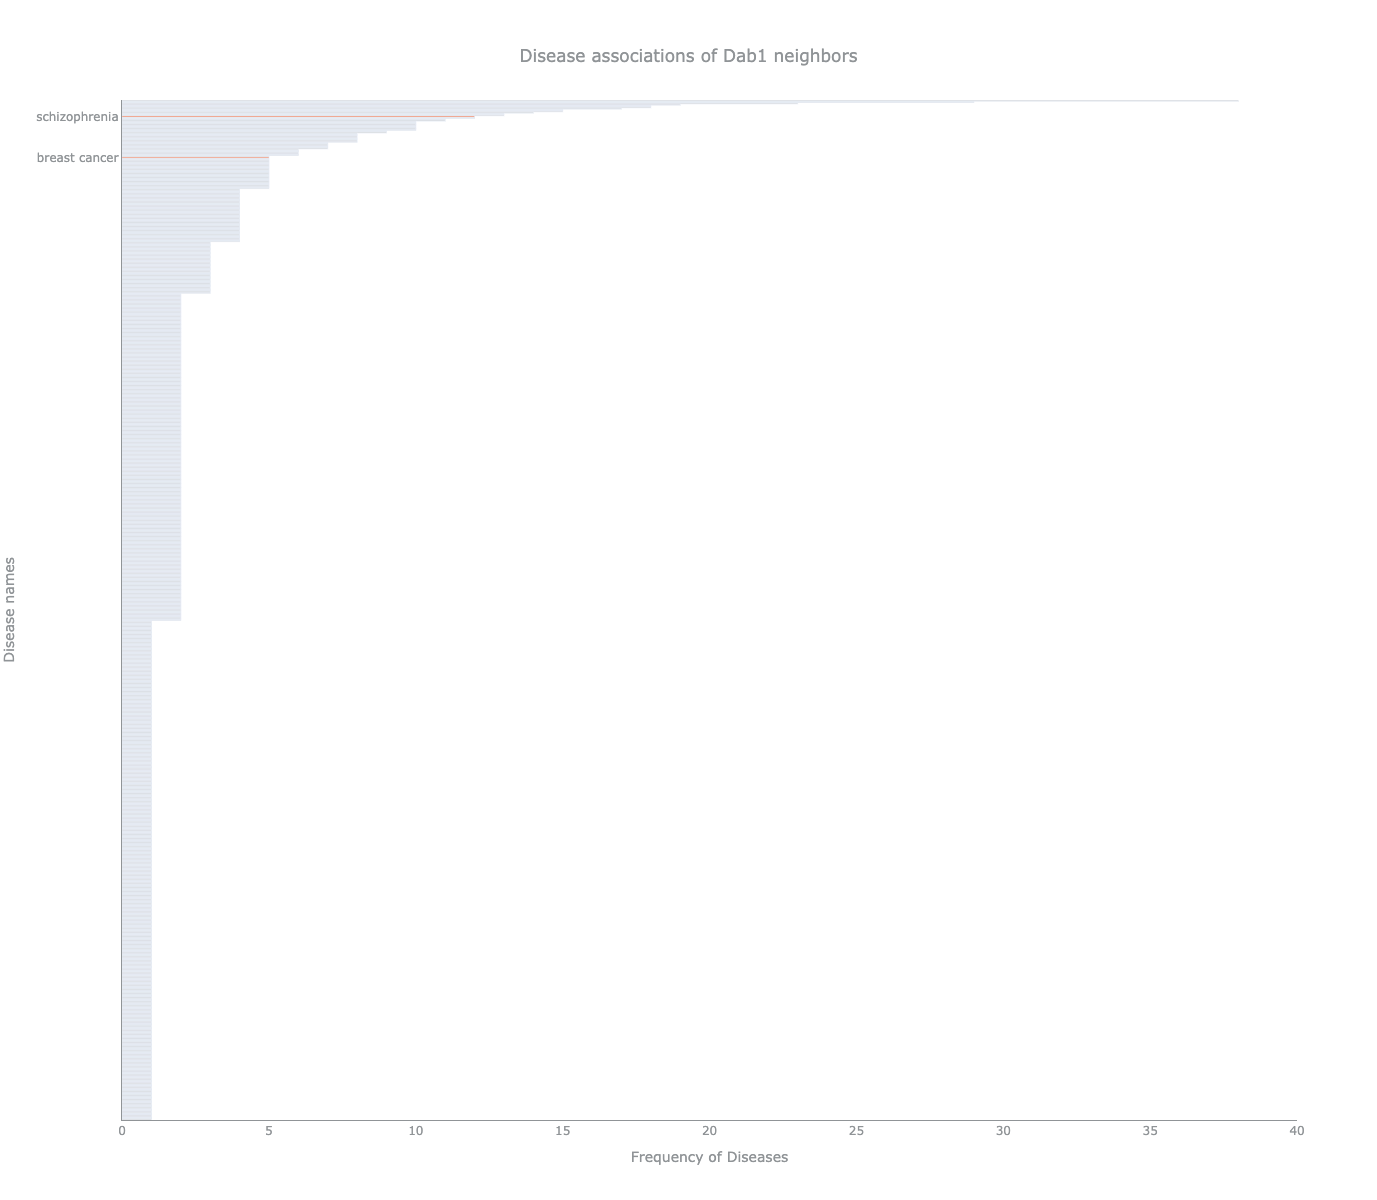

In [ ]:
fig = pgo.Figure()

fig.add_trace(pgo.Bar(y = list(disease_counts_sorted.keys()),
                    x = list(disease_counts_sorted.values()),
                    orientation = "h",
                      marker=dict(color = col_list),
                     )
             )

fig.update_layout(width=800,
                    height=1200,
                    plot_bgcolor = "white",
                    font = dict(color = "#909497"),
                    title = {'text':'Disease associations of Dab1 neighbors',
                            'x':0.5,
                            'yanchor': 'top'},
                    xaxis = dict(title = "Frequency of Diseases", linecolor = "#909497"),
                    yaxis = dict(title = "Disease names", linecolor = "#909497",
                                tickmode = 'array',
                                tickvals = [id_breast, id_schizo],
                                ticktext = [val_breast, val_schizo],
                                )
                 )
#fig['layout']['xaxis']['autorange'] = "reversed"
fig['layout']['yaxis']['autorange'] = "reversed"

fig.show()

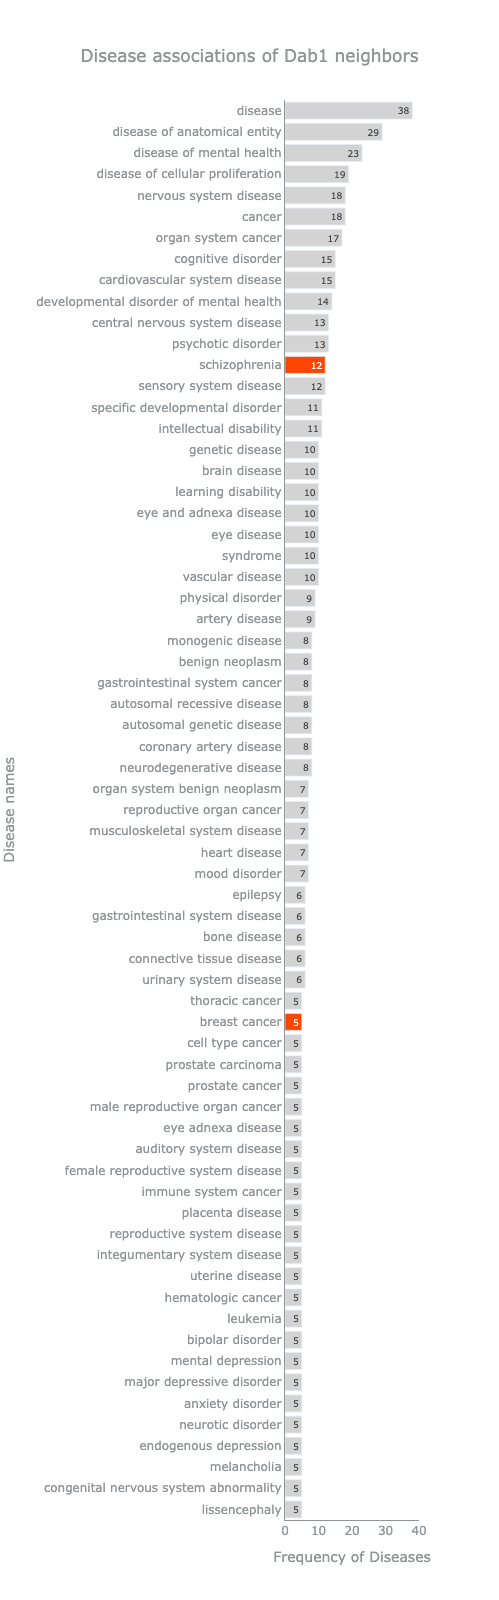

In [ ]:
disease_counts_sorted_cut = {}
for k,v in disease_counts_sorted.items():
    if v >= 5:
        disease_counts_sorted_cut[k]=v
    else:
        pass
    
fig = pgo.Figure()

fig.add_trace(pgo.Bar(y = list(disease_counts_sorted_cut.keys()),
                    x = list(disease_counts_sorted_cut.values()),
                    orientation = "h",
                    marker=dict(color = col_list),
                    texttemplate=list(disease_counts_sorted.values()),
                    textposition="inside",
                    textangle=0,
                     )
             )

fig.update_layout(width=800,
                    height=1600,
                    plot_bgcolor = "white",
                    font = dict(color = "#909497"),
                    title = {'text':'Disease associations of Dab1 neighbors',
                            'x':0.5,
                            'yanchor': 'top'},
                    xaxis = dict(title = "Frequency of Diseases", linecolor = "#909497"), #type="log"),
                    yaxis = dict(title = "Disease names", linecolor = "#909497")
                 )
#fig['layout']['xaxis']['autorange'] = "reversed"
fig['layout']['yaxis']['autorange'] = "reversed"

fig.show()

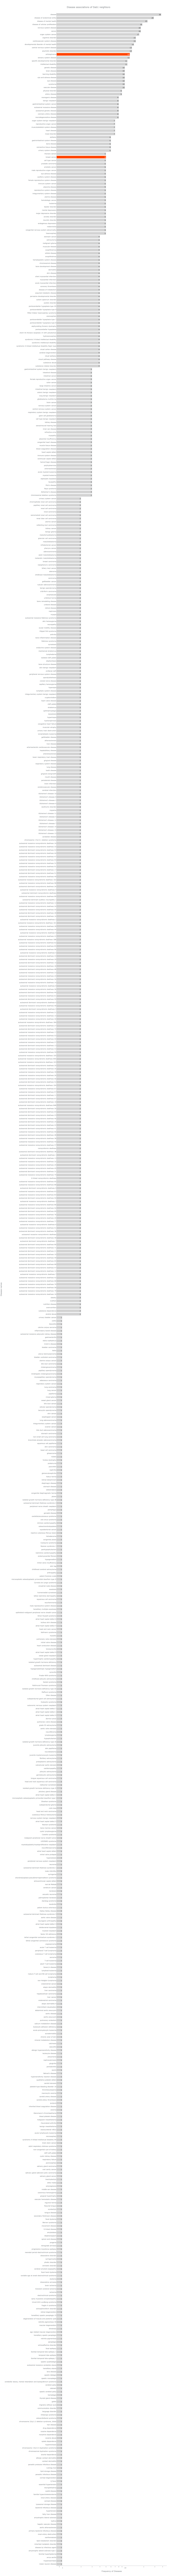

In [ ]:
fig = pgo.Figure()

fig.add_trace(pgo.Bar(y = list(disease_counts_sorted.keys()),
                    x = list(disease_counts_sorted.values()),
                    orientation = "h",
                    marker=dict(color = col_list),
                    texttemplate=list(disease_counts_sorted.values()),
                    textposition="inside",
                     )
             )

fig.update_layout(width=800,
                    height=20000,
                    plot_bgcolor = "white",
                    font = dict(color = "#909497"),
                    title = {'text':'Disease associations of Dab1 neighbors',
                            'x':0.5,
                            'yanchor': 'top'},
                    xaxis = dict(title = "Frequency of Diseases", linecolor = "#909497",type="log"),
                    yaxis = dict(title = "Disease names", linecolor = "#909497",
                                #tickmode = 'array',
                                #tickvals = [id_breast, id_schizo],
                                #ticktext = [val_breast, val_schizo],
                                )
                 )
#fig['layout']['xaxis']['autorange'] = "reversed"
fig['layout']['yaxis']['autorange'] = "reversed"

fig.show()